In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/gdrive', force_remount=True)


Mounted at /gdrive


In [ ]:
from google.colab import drive
import os
# Location of Zip File
#/gdrive/MyDrive/
drive_path = '/gdrive/MyDrive/01 - Module Management/DSCI/Flowers/flowers.zip'
local_path = '/content'



In [ ]:
# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .
# Navigate to the copied file and unzip it quietly


In [ ]:
os.chdir(local_path)
!unzip -q 'flowers.zip'

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

  ##add prediction and preprocessing

#change regex pattern from PetImages\\ to PetImages/
#extract your class labels from folder name
pattern = r'train/'
print(tf.io.gfile.glob("train/*"))
CLASS_NAMES = [item.numpy().decode("utf-8") for item in
               tf.strings.regex_replace(
                 tf.io.gfile.glob("train/*"), #input
                 pattern, "")]
                  #pattern, "" -the new value replacing the input that match the pattern
print(CLASS_NAMES)
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

['train/sunflower', 'train/tulip', 'train/daisy', 'train/dandelion', 'train/rose']
['sunflower', 'tulip', 'daisy', 'dandelion', 'rose']
These are the available classes: ['sunflower', 'tulip', 'daisy', 'dandelion', 'rose']


In [ ]:
#create a list of filenames with its class labels
import pandas as pd

flowersdf = pd.DataFrame(columns=['path', 'class'])
absolutePath = r"train/"

#dynamic link
for i in CLASS_NAMES:

    classPath = tf.io.gfile.glob(absolutePath+ i +"/*.jpg")
    #absolutepath /train/sunflowers/* - all datasets

    paths_df = pd.DataFrame({'path': classPath})
    # Add a column with the current class name
    paths_df['class'] = i

    flowersdf = pd.concat([flowersdf, paths_df], ignore_index=True)

print(flowersdf)

                                              path      class
0     train/sunflower/18250039435_7654bc11be_n.jpg  sunflower
1        train/sunflower/6061177447_d8ce96aee0.jpg  sunflower
2       train/sunflower/19697910486_0086d893a2.jpg  sunflower
3       train/sunflower/16143151468_4f3c033e33.jpg  sunflower
4        train/sunflower/5020805619_6c710793f7.jpg  sunflower
...                                            ...        ...
2741         train/rose/14982802401_a3dfb22afb.jpg       rose
2742       train/rose/16149016979_23ef42b642_m.jpg       rose
2743        train/rose/8524505546_b242bd4928_n.jpg       rose
2744         train/rose/14414117598_cf70df30de.jpg       rose
2745        train/rose/5578760521_e54aca6bed_n.jpg       rose

[2746 rows x 2 columns]


In [ ]:
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(flowersdf["path"], flowersdf["class"],test_size=0.20)

# Create DataFrames from the split data
X_train_df = pd.DataFrame(X_train, columns=["path"])
X_test_df = pd.DataFrame(X_test, columns=["path"])

# Concatenate paths and labels for training and testing data
trainData = pd.concat([X_train_df, y_train], axis=1)
testData = pd.concat([X_test_df, y_test], axis=1)

trainData.to_csv("train.csv",index=False, header=False)
testData.to_csv("test.csv",index=False, header=False)
print(trainData)

                                              path      class
278    train/sunflower/9681915384_b3b646dc92_m.jpg  sunflower
627        train/tulip/8838354855_c474fc66a3_m.jpg      tulip
1478        train/daisy/11870378973_2ec1919f12.jpg      daisy
1028        train/tulip/14067456066_87e15792d0.jpg      tulip
209   train/sunflower/21728822928_9f6817325a_n.jpg  sunflower
...                                            ...        ...
1357        train/daisy/10555749515_13a12a026e.jpg      daisy
1481       train/daisy/5110109540_beed4ed162_m.jpg      daisy
609        train/tulip/5665708521_799585d229_n.jpg      tulip
630       train/tulip/13529687904_3d60abb479_n.jpg      tulip
1193         train/daisy/4268817944_cdbdb226ae.jpg      daisy

[2196 rows x 2 columns]


In [ ]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

#initialise class
class _Preprocessor:
    def __init__(self):
        self.preproc_layers = tf.keras.Sequential([
            tf.keras.layers.Lambda(
                lambda img: tf.image.resize_with_pad(
                    img, 2*IMG_HEIGHT, 2*IMG_WIDTH),
                input_shape=(None, None, 3)),
            tf.keras.layers.experimental.preprocessing.CenterCrop(
                height=IMG_HEIGHT, width=IMG_WIDTH)
        ])

    #read dataset - replace read from tfr
    def decode_csv(self, csv_row):
      record_defaults = ["path", "flower"]
      filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
      img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
      label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
      return img, label

    #read and decode function
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img

    def preprocess(self, img):
        # add to a batch, call preproc, remove from batch
        x = tf.expand_dims(img, 0)
        x = self.preproc_layers(x)
        x = tf.squeeze(x, 0)
        return x

#pattern - csv file
def create_preproc_dataset(pattern):
    preproc = _Preprocessor()
    trainds = tf.data.TextLineDataset(
    pattern).map(preproc.decode_csv).map(
        lambda img, label: (preproc.preprocess(img), label))
    return trainds

def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)

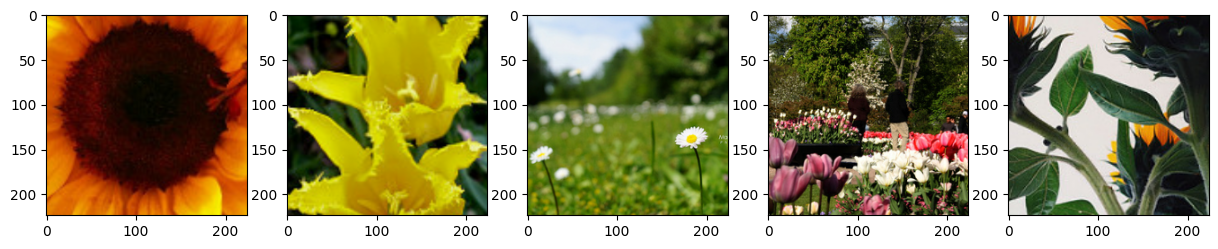

In [ ]:
train_dataset = create_preproc_dataset('train.csv')
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label) in enumerate(train_dataset.take(5)):
    ax[idx].imshow((img.numpy()));

In [ ]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 10,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    # WARNING! training on a small subset dataset (note pattern)
    train_dataset = create_preproc_dataset(
        'train.csv'
    ).batch(batch_size)
    eval_dataset = create_preproc_dataset(
        'test.csv'
    ).batch(batch_size)

    layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer,
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES),
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]

    model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=3)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (Keras  (None, 1280)              2257984   
 Layer)                                                          
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2278565 (8.69 MB)
Trainable params: 20581 (80.39 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
None
Epoch 1/3
220/220 [==============================] - 13s 42ms/step - loss: 0.6003 - accuracy: 0.7864 - val_loss: 0.4415 - val_accuracy: 0.8327
Epoch 2/3
220/220 [==============================] - 8

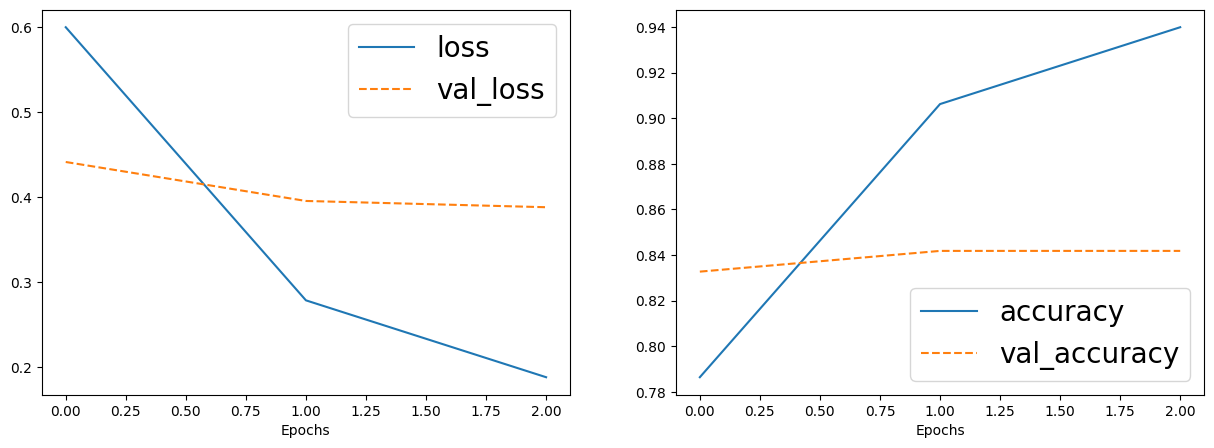

In [ ]:
model = train_and_evaluate()

In [ ]:
# Call model.predict() on a few images in evaluation dataset
def plot_predictions(model, pattern):
    dataset = create_preproc_dataset(pattern)
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

plot_predictions(model, 'test.csv')

Output hidden; open in https://colab.research.google.com to view.